In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
import utils
from imagenet_classes import class_names
from VGG import generate_VGG16

In [4]:
print("TensorFlow version : {}".format(tf.__version__))
print("Devices : {}".format(utils.get_tensorflow_devices()))

TensorFlow version : 1.2.0
Devices : [('/cpu:0', 'CPU')]


In [5]:
###############################################################################
# Constants for the image input and output.
###############################################################################
LOGS = 'logs/2.0'
# Output folder for the images.
OUTPUT_DIR = 'output/'
# Style image to use.
STYLE_IMAGE = 'images/udnie.jpg'
# Content image to use.
CONTENT_IMAGE = 'images/hongkong.jpg'
# Image dimensions constants. 

IMG_W = 720
IMG_H = 720
CHANNELS = 3

MODEL_WEIGHTS = 'data/VGG/vgg16.npy'

In [6]:
if tf.gfile.Exists(LOGS):
    tf.gfile.DeleteRecursively(LOGS)
tf.gfile.MakeDirs(LOGS)

In [6]:
###############################################################################
# Algorithm constants
###############################################################################
# Noise ratio. Percentage of weight of the noise for intermixing with the
# content image.
NOISE_RATIO = 0.7
# Constant to put more emphasis on content loss.
BETA = 5
# Constant to put more emphasis on style loss.
ALPHA = 25

In [7]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.InteractiveSession(config=config)

In [9]:
model, vgg_scope = generate_VGG16(weights_file=MODEL_WEIGHTS,
                                  apply_preprocess=True,
                                  remove_top=True,
                                  input_shape=(1, IMG_W, IMG_H, CHANNELS))

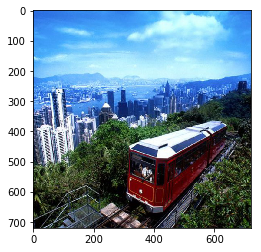

In [10]:
from scipy.misc import imread, imresize
content_image = imread(CONTENT_IMAGE)

short_edge = min(content_image.shape[:2])
yy = int((content_image.shape[0] - short_edge) / 2)
xx = int((content_image.shape[1] - short_edge) / 2)
content_image = content_image[yy: yy + short_edge, xx: xx + short_edge]

content_image = imresize(content_image, (IMG_W, IMG_H))
content_image = content_image.reshape((1, IMG_W, IMG_H, CHANNELS))

plt.imshow(content_image[0])

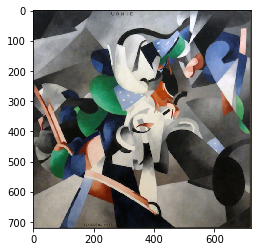

In [11]:
style_image = utils.load_image(STYLE_IMAGE, expand_dim=True, width=IMG_W, height=IMG_H)
plt.imshow(style_image[0])

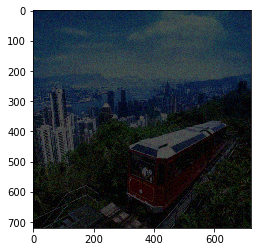

In [12]:
noise_image = np.random.uniform( -20, 20, (1, IMG_H, IMG_W, CHANNELS)).astype('float32')
noise_image = noise_image * NOISE_RATIO + content_image * (1 - NOISE_RATIO)
plt.imshow(np.clip(noise_image[0], 0, 255).astype('uint8'))

In [13]:
sess.run(tf.global_variables_initializer())

In [14]:
def content_loss_func(sess, model):
    """
    Content loss function as defined in the paper.
    """
    def _content_loss(target_content, x):
        """
        target_content : numpy array
        x : tensor (current content)
        """
        return tf.reduce_mean(tf.pow(target_content - x, 2))
    return _content_loss(sess.run(model['conv2_2']), model['conv2_2'])

with tf.name_scope('content_images'):
    # Construct content_loss using content_image.
    sess.run(model['input'].assign(content_image))

with tf.name_scope('content_loss'):
    content_loss = content_loss_func(sess, model)
    tf.summary.scalar('content_loss', content_loss)

In [15]:
STYLE_LAYERS = [
    ('conv1_2', 1.0),
    ('conv2_2', 1.0),
    ('conv3_3', 1.0),
    ('conv4_3', 1.0)
]

def style_loss_func(sess, model):
    """
    Style loss function as defined in the paper.
    """
    def _gram_matrix(F, N, M):
        """
        The gram matrix G.
        """
        Ft = tf.reshape(F, (M, N))
        return (1/M)*tf.matmul(tf.transpose(Ft), Ft)

    def _style_loss(a, x):
        """
        a : target, numpy array (feature maps)
        x : feature maps (tensor)
        """
        # N is the number of filters (at layer l).
        N = a.shape[3]
        # M is the height times the width of the feature map (at layer l).
        M = a.shape[1] * a.shape[2]
        
        # G_target is the style representation of the original image (at layer l).
        G_target = _gram_matrix(a, N, M)
        
        # G is the style representation of the generated image (at layer l).
        G = _gram_matrix(x, N, M)
        # result = (1 / (4 * N**2 * M**2)) * tf.reduce_sum(tf.pow(G - A, 2))
        
        result = tf.reduce_mean(tf.pow(G_target - G, 2))
        return result

    E = [_style_loss(sess.run(model[layer_name]), model[layer_name]) for layer_name, _ in STYLE_LAYERS]
    W = [w for _, w in STYLE_LAYERS]
    loss = sum([W[l] * E[l] for l in range(len(STYLE_LAYERS))])
    return loss

with tf.name_scope('style_images'):
    # Construct style_loss using style_image.
    sess.run(model['input'].assign(style_image))

with tf.name_scope('style_loss'):
    style_loss = style_loss_func(sess, model)
    tf.summary.scalar('style_loss', style_loss)

In [16]:
with tf.name_scope('total_loss'):
    total_loss = BETA * content_loss + ALPHA * style_loss
    tf.summary.scalar('total_loss', total_loss)

In [17]:
merged = tf.summary.merge_all()
writer = tf.summary.FileWriter(LOGS, sess.graph)

In [18]:
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(2.0)
    train_step = optimizer.minimize(total_loss)

In [ ]:
sess.run(tf.global_variables_initializer())
_ = sess.run(model['input'].assign(noise_image))

In [ ]:
%%time

ITERATIONS = 300

for it in range(ITERATIONS):
    
    if it == 49 : 
        run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
        run_metadata = tf.RunMetadata()
        
        summary, _ = sess.run([merged, train_step],
                              options=run_options,
                              run_metadata=run_metadata)
            
        writer.add_summary(summary, it)
        writer.add_run_metadata(run_metadata, 'step%03d' % it)
            
    else :
        summary, _ = sess.run([merged, train_step])
        writer.add_summary(summary, it)

    if it%10 == 0:
        
        
        _image = sess.run(model['input'])
        print('Iteration %d' % (it))
        print('cost: ', sess.run(total_loss))
        filename = 'output/stylized_gatys_iter{}.png'.format(it)
        utils.save_image(filename, _image)

        
_image = sess.run(model['input'])
print('Iteration %d' % (it))
print('cost: ', sess.run(total_loss))
filename = 'output/stylized_gatys_iter{}.png'.format(it)
utils.save_image(filename, _image)

Iteration 0
cost:  2.955e+10
Iteration 10
cost:  1.47782e+10
Iteration 20
cost:  1.07332e+10
Iteration 30
cost:  8.65513e+09
Iteration 40
cost:  7.21235e+09
Iteration 50
cost:  6.12155e+09
Iteration 60
cost:  5.29058e+09
Iteration 70
cost:  4.63634e+09
Iteration 80
cost:  4.10543e+09
Iteration 90
cost:  3.66913e+09
Iteration 100
cost:  3.30472e+09
Iteration 110
cost:  2.99624e+09
Iteration 120
cost:  2.73296e+09
Iteration 130
cost:  2.50608e+09
Iteration 140
cost:  2.30846e+09
Iteration 150
cost:  2.13462e+09
Iteration 160
cost:  1.98026e+09
Iteration 170
cost:  1.84232e+09
Iteration 180
cost:  1.71827e+09
Iteration 190
cost:  1.606e+09
Iteration 200
cost:  1.50359e+09
Iteration 210
cost:  1.40928e+09
Iteration 220
cost:  1.32198e+09
Iteration 230
cost:  1.24059e+09
Iteration 240
cost:  1.16426e+09
Iteration 250
cost:  1.09249e+09
Iteration 260
cost:  1.02586e+09
Iteration 270
cost:  9.62376e+08
Iteration 280
cost:  9.01936e+08


In [ ]:
writer.close()